In [1]:
import os
import h5py
import glob
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
files = sorted(glob.glob("GPM_DPR_2024/*.HDF5"))
f = h5py.File(files[0], 'r')
print(list(f.keys()))
print(list(f['FS'].keys()))
print(list(f['HS'].keys()))
print(list(f['AlgorithmRuntimeInfo']))
print(list(f['FS/PRE'].keys()))
print(list(f['FS/CSF'].keys()))

['FS', 'HS', 'AlgorithmRuntimeInfo']
['ScanTime', 'scanStatus', 'navigation', 'PRE', 'VER', 'CSF', 'SRT', 'DSD', 'Experimental', 'SLV', 'FLG', 'TRG', 'Latitude', 'Longitude', 'sunLocalTime']
['ScanTime', 'scanStatus', 'navigation', 'PRE', 'VER', 'CSF', 'SRT', 'DSD', 'Experimental', 'SLV', 'FLG', 'Latitude', 'Longitude', 'sunLocalTime']
[np.bytes_(b'2A.GPM.Ku.V9-20211125.20180105-S083313-E100547.021900.V07A.HDF5,2A.GPM.Ka.V9-20211125.20180105-S083313-E100547.021900.V07A.HDF5\nPRE(from Ku product)/kuns_adjust_factor_07A_20211020.dat\nPRE(from Ka product)/kams_adjust_factor_07A_20211020.dat\nPRE(from Ka product)/kahs_adjust_factor_07A_20211020.dat\nVER/DPR-L2_VER_CLW-DB_ver20150508.dat\nCSF/w_outDPR_CSF.txt\nDSD/log10eps_5deg_v20210705_0006.dat\nDSD/log10eps_5deg_v20210527_0125.dat\nDSD/log10eps_5deg_v20210705_0006.dat\nTRG/TRG_params.txt\nTRG/TRG_sample_LUT.dat\nSRT/Temporal_0.5F_4YDJF2018_6S_ITE748PRE_UF.bin\nSLV/lut_2015_0827_wibb_nw_dm_m3.dat\nSLV/lut_2015_0827_wobb_nw_dm_m3.dat\nSLV/

In [3]:

file = "GPM_DPR_2024\GPM_2ADPR.07ː2A.GPM.DPR.V9-20211125.20180105-S083313-E100547.021900.V07A.HDF5"  
with h5py.File(file, 'r') as f:
    # FS/CSF group
    flagBB = f['FS/CSF/flagBB'][:]        # Bright Band flag
    heightBB = f['FS/CSF/heightBB'][:]    # Bright Band height
    qualityBB = f['FS/CSF/qualityBB'][:]  # Bright Band quality index

    # FS/PRE group
    zFactorMeasured = f['FS/PRE/zFactorMeasured'][:]  # Reflectivity profile (dBZ)

print("flagBB shape:", flagBB.shape)
print("heightBB shape:", heightBB.shape)
print("qualityBB shape:", qualityBB.shape)
print("zFactorMeasured shape:", zFactorMeasured.shape)


flagBB shape: (7937, 49)
heightBB shape: (7937, 49)
qualityBB shape: (7937, 49)
zFactorMeasured shape: (7937, 49, 176, 2)


In [4]:
# --- Settings ---
INPUT_FOLDER = "GPM_DPR_2024"   # your folder
FILES = sorted(glob.glob(f"{INPUT_FOLDER}/*.HDF5"))
print(f"Found {len(FILES)} files")

def build_masks(flagBB, heightBB, qualityBB, vert_heights):
    """
    Build binary masks (time, beams, height).
    Mask=1 if bin near heightBB, else 0.
    """
    T, B = flagBB.shape
    V = vert_heights.shape[-1]
    masks = np.zeros((T, B, V), dtype=np.uint8)

    def height_to_bin(h, vcenters):
        if np.isnan(h): return None
        return int(np.argmin(np.abs(vcenters - h)))

    for t in range(T):
        for b in range(B):
            if flagBB[t, b] == 1 and qualityBB[t, b] > 0:
                h = heightBB[t, b]
                vcenters = vert_heights if vert_heights.ndim == 1 else vert_heights[t, b, :]
                idx = height_to_bin(h, vcenters)
                if idx is not None:
                    lo, hi = max(0, idx-2), min(V, idx+3)
                    masks[t, b, lo:hi] = 1
    return masks

# --- Collect all images/masks ---
all_images = []
all_masks = []

for fname in tqdm(FILES, desc="Processing files"):
    with h5py.File(fname, "r") as f:
        z = f['FS/PRE/zFactorMeasured'][:]    # (T, B, V, C)
        flagBB = f['FS/CSF/flagBB'][:]
        heightBB = f['FS/CSF/heightBB'][:]
        qualityBB = f['FS/CSF/qualityBB'][:]
        
        # vertical heights (if available)
        if 'FS/PRE/height' in f['FS/PRE']:
            vert_heights = f['FS/PRE/height'][:]
            if vert_heights.ndim == 1:
                vcenters = vert_heights
            else:
                vcenters = vert_heights
        else:
            vcenters = np.arange(z.shape[2])
        
        # Build masks
        masks = build_masks(flagBB, heightBB, qualityBB, vcenters)  # (T, B, V)
        
        # Reshape for images
        # Input: (T, height=V, beams=B, channels=C)
        imgs = np.transpose(z, (0, 2, 1, 3))   # (T, V, B, C)
        labs = np.transpose(masks, (0, 2, 1))  # (T, V, B)
        
        all_images.append(imgs)
        all_masks.append(labs)

# Concatenate across files
X = np.concatenate(all_images, axis=0)   # (N, 176, 49, C)
Y = np.concatenate(all_masks, axis=0)    # (N, 176, 49)

print("Final dataset shapes:", X.shape, Y.shape)


Found 1 files


Processing files: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


Final dataset shapes: (7937, 176, 49, 2) (7937, 176, 49)


In [5]:
# Handle missing values
X[X < -100] = np.nan   # DPR fill values

# Scale to [-1, 1]
vmin = np.nanmin(X)
vmax = np.nanmax(X)
X = (X - vmin) / (vmax - vmin + 1e-9) * 2 - 1
X = np.nan_to_num(X, nan=-1.0)


In [6]:


X_resized = []
Y_resized = []
for i in range(X.shape[0]):
    xi = X[i]     # (176, 49, C)
    yi = Y[i]     # (176, 49)
    
    # Resize to (256, 256)
    xi_res = cv2.resize(xi, (256, 256), interpolation=cv2.INTER_LINEAR)
    yi_res = cv2.resize(yi.astype(np.float32), (256, 256), interpolation=cv2.INTER_NEAREST)
    
    X_resized.append(xi_res)
    Y_resized.append(yi_res)

X = np.stack(X_resized)
Y = np.stack(Y_resized)[..., np.newaxis]   # add channel

print("Resized shapes:", X.shape, Y.shape)


Resized shapes: (7937, 256, 256, 2) (7937, 256, 256, 1)


In [7]:
N = X.shape[0]
n_train = int(0.85 * N)
n_val = int(0.05 * N)
n_test = N - n_train - n_val

X_train, Y_train = X[:n_train], Y[:n_train]
X_val,   Y_val   = X[n_train:n_train+n_val], Y[n_train:n_train+n_val]
X_test,  Y_test  = X[n_train+n_val:], Y[n_train+n_val:]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (6746, 256, 256, 2) Val: (396, 256, 256, 2) Test: (795, 256, 256, 2)


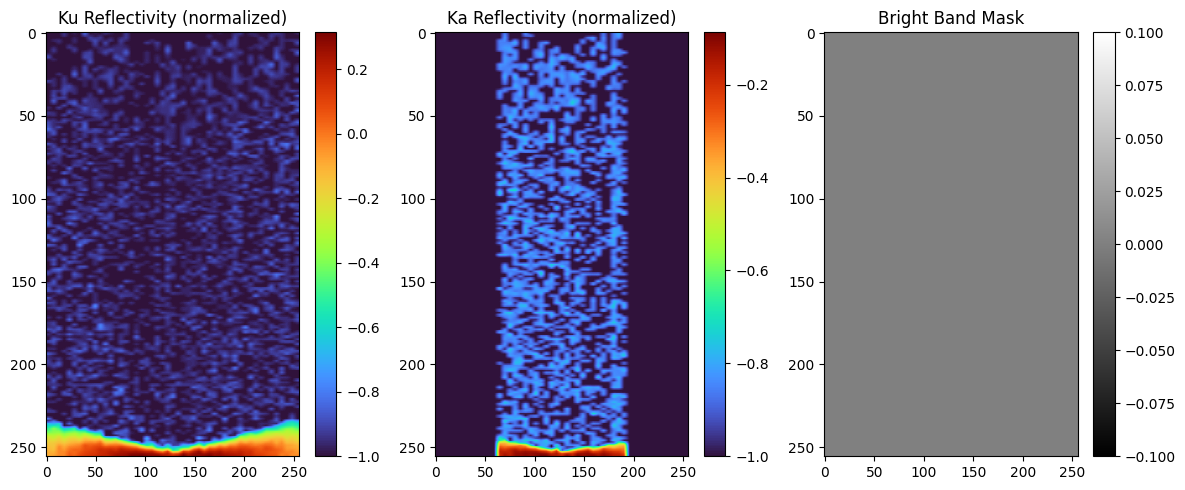

In [8]:
import matplotlib.pyplot as plt
import random

# Pick a random sample
i = random.randint(0, X.shape[0]-1)
xi = X[i]        # (256, 256, C)
yi = Y[i, :, :, 0]   # (256, 256)

# If you only want Ku channel (channel 0)
ku = xi[:, :, 0]

# If Ka available (channel 1)
if xi.shape[-1] > 1:
    ka = xi[:, :, 1]
else:
    ka = None

# Plot
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.title("Ku Reflectivity (normalized)")
plt.imshow(ku, aspect='auto', cmap='turbo')
plt.colorbar()

if ka is not None:
    plt.subplot(1,3,2)
    plt.title("Ka Reflectivity (normalized)")
    plt.imshow(ka, aspect='auto', cmap='turbo')
    plt.colorbar()

plt.subplot(1,3,3)
plt.title("Bright Band Mask")
plt.imshow(yi, aspect='auto', cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * inter + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def combo_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def build_unet(input_shape=(256, 256, 2), base_filters=64, depth=4, dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    skips = []
    # encoder
    for d in range(depth):
        f = base_filters * (2**d)
        x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
        skips.append(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(dropout_rate)(x)
    # bottleneck
    f = base_filters * (2**depth)
    x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
    # decoder
    for d in reversed(range(depth)):
        f = base_filters * (2**d)
        x = layers.UpSampling2D()(x)
        x = layers.Concatenate()([x, skips[d]])
        x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=5e-3),
                  loss=combo_loss,
                  metrics=['accuracy'])
    return model

model = build_unet(input_shape=X_train.shape[1:])
model.summary()


ImportError: Traceback (most recent call last):
  File "c:\Users\navar\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("unet_dpr.h5", save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=8,
    callbacks=callbacks
)


In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss, "Test Accuracy:", test_acc)

# Example prediction
i = 0
pred = model.predict(X_test[i:i+1])[0,:,:,0]
